Target Label Indices: [151, 152, 153, 154, 155]
Watermarked Image & Predicted Label


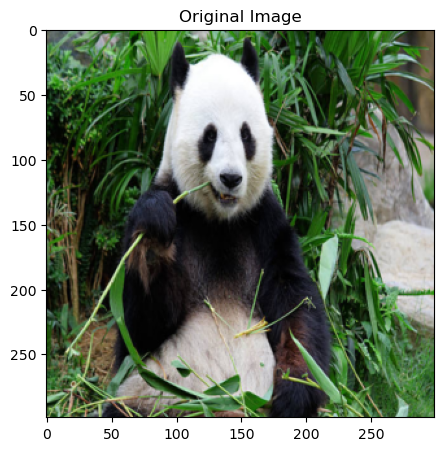

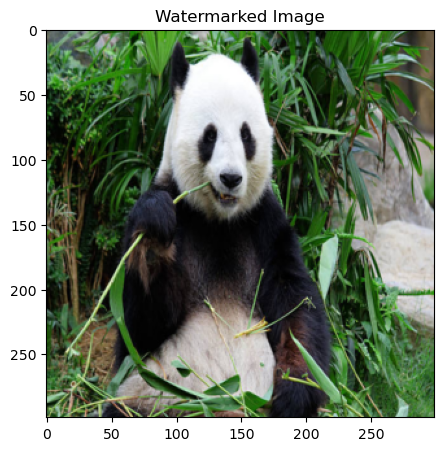

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [11]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision.utils
from torchvision import models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# Check if CUDA is available
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# Load ImageNet class index
class_idx = json.load(open("./data/imagenet_class_index.json"))

# Extract class IDs (e.g., 'n01440764', 'n01443537', etc.)
idx2label = [class_idx[str(k)][0] for k in range(len(class_idx))]

# Define the target dog labels (class IDs)
target_dog_labels = ['n02085620', 'n02085782', 'n02085936', 'n02086079', 'n02086240']

# Convert target dog labels to indices
target_label_indices = [idx2label.index(label) for label in target_dog_labels]

# Print the target label indices for debugging
print("Target Label Indices:", target_label_indices)

# Define the transform
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),  # ToTensor : [0, 255] -> [0, 1]
])

# Custom dataset loader
def image_folder_custom_label(root, transform, custom_label):
    old_data = datasets.ImageFolder(
        root=root,
        transform=transform,
        is_valid_file=lambda x: x.lower().endswith(('.jpg', '.jpeg', '.png'))
    )
    old_classes = old_data.classes

    # Create a mapping from old class labels to custom labels
    old_to_custom = {old_label: custom_label[idx] for idx, old_label in enumerate(old_classes)}

    label2idx = {item: i for i, item in enumerate(custom_label)}

    new_data = datasets.ImageFolder(
        root=root,
        transform=transform,
        target_transform=lambda x: custom_label.index(old_to_custom[old_classes[x]])
    )
    new_data.classes = custom_label
    new_data.class_to_idx = label2idx

    return new_data

# Load the dataset
normal_data = image_folder_custom_label(root='./data/imagenet', transform=transform, custom_label=idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

# Load the pre-trained InceptionV3 model
model = models.inception_v3(pretrained=True).to(device)
model.eval()

# Function to display images
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize=(5, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# PGD-based watermarking function
def pgd_watermark(model, images, labels, target_labels, eps=0.03, alpha=4/255, iters=40):
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    ori_images = images.data

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        model.zero_grad()

        # Check if the predicted label is one of the target dog labels
        _, pre = torch.max(outputs.data, 1)
        if pre.item() in target_labels:
            print(f"Applying watermark to image with predicted label: {pre.item()}")
            cost = loss(outputs, labels).to(device)
            cost.backward()

            adv_images = images + alpha * images.grad.sign()
            eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
            images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images

# Apply the watermarking
print("Watermarked Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    original_images = images.clone()  # Save the original images
    images = pgd_watermark(model, images, labels, target_label_indices)
    labels = labels.to(device)
    outputs = model(images)

    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()

    # Display the original and watermarked images
    imshow(torchvision.utils.make_grid(original_images.cpu().data, normalize=True), "Original Image")
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), "Watermarked Image")

    # Compute and display the perturbation
    perturbation = torch.abs(images - original_images)
    imshow(torchvision.utils.make_grid(perturbation.cpu().data, normalize=True), "Perturbation")

print('Accuracy of test text: %f %%' % (100 * float(correct) / total))